In [243]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
import matplotlib.pyplot as plt
import sqlalchemy
import configparser

# show graphs right in the notebook (rather than in another window)
%matplotlib inline

### Загружаем данные из БД

In [244]:
parser = configparser.ConfigParser()
parser.read('db.config')

config = parser['DEFAULT']

engine = sqlalchemy.create_engine(
        'mssql+pyodbc://' + config['username'] + 
        ':' + config['password'] + '@' + config['server'] 
        + '/' + config['database'] + "?" + config['driver'])


df = pd.io.sql.read_sql("select * from PlayersStats", engine)
df = pd.DataFrame.dropna(df.iloc[:, 1:])
df.head()

,Height,Weight,Age
0,185.0,81.45,29.0
1,180.0,72.45,30.0
2,202.5,99.00,20.0
3,205.0,106.65,24.0
4,205.0,110.25,29.0


### Обучаем линейную модель

In [245]:
x = df.loc[:,["Height", "Age"]]
y = df.loc[:,"Weight"]

slm = lm.LinearRegression()
slm.fit(x, y)
slm.intercept_, slm.coef_, slm.score(x, y)

(-141.19959334427756, array([1.19072481, 0.20253595]), 0.7162921463572308)

### Оцениваем качество

In [246]:
scores = model_selection.cross_val_score(slm, x, y, cv=10, scoring='r2')
scores.mean(), scores.std()

(0.7059879768402724, 0.052376743929920234)

### Визуализируем

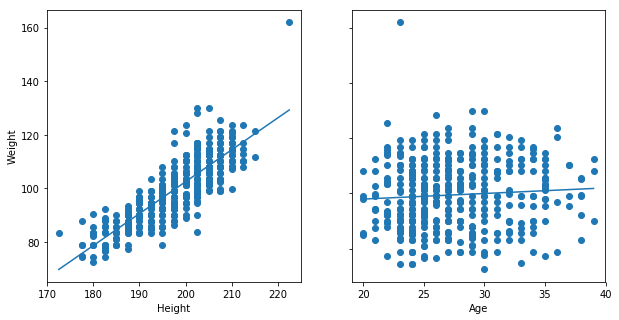

In [250]:
labels = ['Height', 'Age']
plt.rcParams["figure.figsize"] = (10,5)

for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    plt.xlabel(labels[i])
    if (i == 0):
        plt.ylabel('Weight')
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    cur_column = x[labels[i]]
    # actual data
    plt.scatter(cur_column, y)
    # prediction
    other_column = x[labels[1 - i]]
    line_xs = [cur_column.min(), cur_column.max()]
    m = other_column.mean()
    line_ys = []
    for x_ in line_xs:
        instance = [[0, 0]]
        instance[0][i] = x_
        instance[0][1 - i] = m
        line_ys.append(slm.predict(instance))
    plt.plot(line_xs, line_ys)

plt.show()
